In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('../data/processed_data/scopus_data_doi_cleaned_with_projections.csv')
df.head(3)

,title,abstract,year,coverdate,publication_name,citation_count,subject_areas,author_names,affiliations,countries,file_name,doi,orig_text,text,x,y
0,Artificial neural network prediction of transp...,Novel N-methyl-4-piperidinol (MPDL)-based solv...,2022,2022-08-01,Energy Reports,4.0,Energy (all),Nimmanterdwong P.+Janthboon P.+Tontiwachwuthik...,Chulalongkorn University+Clean Energy Technolo...,Thailand+Canada+China,202201532.json,10.1016/j.egyr.2022.02.117,Artificial neural network prediction of transp...,artificial neural network prediction transport...,49.010216,-38.129470
1,Light-assisted synthesis of Au/TiO2 nanopartic...,A series of Au/TiO2 photocatalysts was synthes...,2022,2022-07-01,International Journal of Hydrogen Energy,20.0,"Renewable Energy, Sustainability and the Envir...",Kunthakudee N.+Puangpetch T.+Ramakul P.+Seriva...,Chulalongkorn University+Silpakorn University+...,Thailand,202201728.json,10.1016/j.ijhydene.2022.05.150,Light-assisted synthesis of Au/TiO2 nanopartic...,light assisted synthesis au tio2 nanoparticles...,71.834885,-29.072338
2,Competition and epibiosis by the sponge Pseudo...,Competition for space on coral reefs is fierce...,2022,2022-01-01,Regional Studies in Marine Science,3.0,"Ecology, Evolution, Behavior and Systematics+A...",Allchurch A.+Mehrotra R.+Carmody H.+Monchanin ...,The University of Western Australia+Chulalongk...,Australia+Thailand+Canada+United States+France,202204089.json,10.1016/j.rsma.2021.102131,Competition and epibiosis by the sponge Pseudo...,competition epibiosis sponge pseudoceratina pu...,50.856255,68.591140


<Axes: xlabel='x', ylabel='y'>

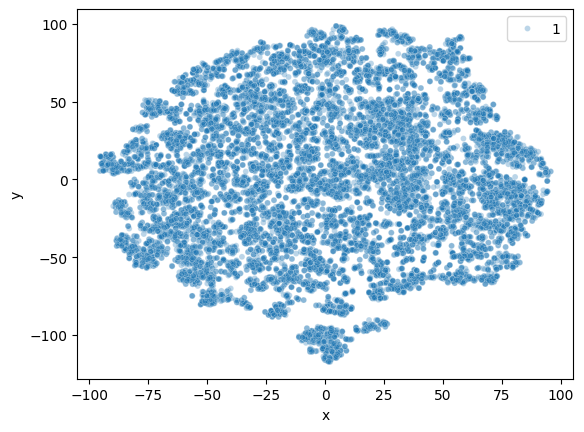

In [3]:
sns.scatterplot(data=df, x='x', y='y', alpha=0.3, size=1)

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

#Scale x, y coordinates
scaler = StandardScaler()
df[['x', 'y']] = scaler.fit_transform(df[['x', 'y']])

#Elbow method to find optimal number of clusters
inertia = []
meandistortions = []
K = range(1, 200, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[['x', 'y']])
    inertia.append(kmeans.inertia_)
    meandistortions.append(sum(np.min(cdist(df[['x', 'y']], kmeans.cluster_centers_, 'euclidean'), axis=1)) / df[['x', 'y']].shape[0])



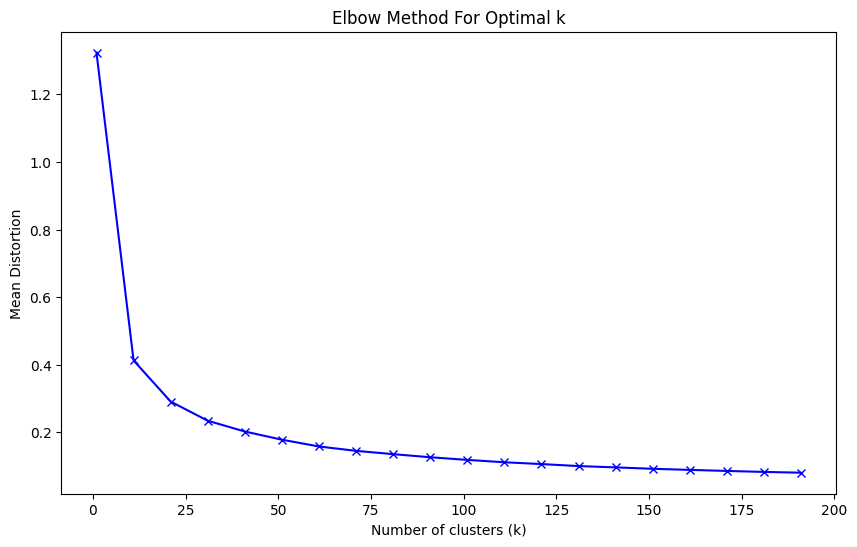

In [5]:
#Plotting the elbow curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Mean Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

In [36]:
best_clusters = 25

<Axes: xlabel='x', ylabel='y'>

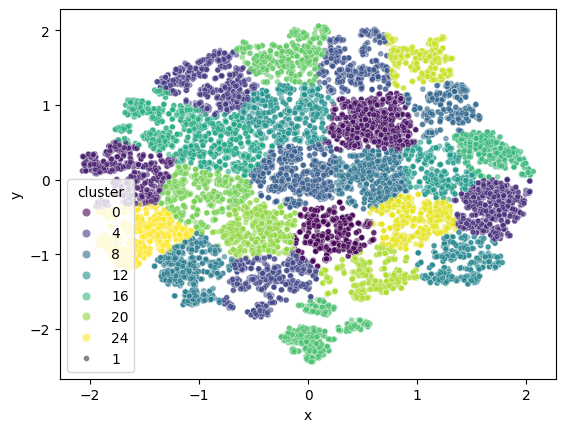

In [37]:
kmeans = KMeans(n_clusters=best_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['x', 'y']])

#plot the cluster
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.6, size=1)

In [44]:
df.to_csv('../data/processed_data/scopus_data_cleansed_clusters.csv', index=False)

In [39]:
import ollama

def get_cluster_label_local(titles_list):
    # Join titles into a clean list
    formatted_list = "\n".join([f"- {t}" for t in titles_list])
    
    prompt = f"""
    Analyze the following list of document titles and generate a concise, 
    3-5 word category label that best describes them try to be general.
    
    Return ONLY the label. NO explanations. NO bullet points.
    
    Titles:
    {formatted_list}
    """
    
    try:
        response = ollama.chat(model='llama3.2:3b', messages=[
            {
                'role': 'user',
                'content': prompt,
            },
        ])
        return response['message']['content'].strip()
    except Exception as e:
        return f"Error: {e}"

In [23]:
cluster_0 = df[df['cluster'] == 0]
topic = get_cluster_label_local(cluster_0['title'].sample(50).tolist())
topic

'Science and Technology Research'

In [40]:
clear_labels = {}

for cluster in df.cluster.unique():
    cluster_df = df[df['cluster'] == cluster]
    topic_label = get_cluster_label_local(cluster_df['title'].sample(50).tolist())
    topic_label = topic_label.split('\n')[0]  # Get only the first line in case of extra newlines
    print(f"Cluster {cluster}: {topic_label}")
    clear_labels[cluster] = topic_label

Cluster 23: Materials Science Research
Cluster 3: Energy and Chemicals
Cluster 22: Biology Research Articles
Cluster 6: Science Research Studies
Cluster 14: Medical Research Studies
Cluster 7: Dental and Oral Health
Cluster 17: Particle Physics and Cosmology
Cluster 15: - Cardiovascular Disease Research
Cluster 5: Electrical Engineering Research
Cluster 20: Computer Vision & Machine
Cluster 12: Diseases & Disorders
Cluster 1: Medicinal Plants
Cluster 18: Vaccine and infectious diseases research
Cluster 24: Higher Education Studies
Cluster 10: Business, Technology
Cluster 2: Healthcare Sciences Research
Cluster 9: Nanotechnology Applications
Cluster 8: Microbial Research Studies
Cluster 21: Engineering Research Papers
Cluster 0: Environmental Science and Management
Cluster 16: Electrochemistry Sensors
Cluster 13: Environmental Engineering & Science
Cluster 19: Health and Medical Research
Cluster 4: Gastrointestinal Oncology
Cluster 11: Materials Science Research


In [41]:
#Strip non alphabetical characters at the start and end of the labels
for cluster, label in clear_labels.items():
    clear_labels[cluster] = label.strip(" .,-_!@#$%^&*()[]{};:'\"<>?/\\|`~")

print(clear_labels)

{np.int32(23): 'Materials Science Research', np.int32(3): 'Energy and Chemicals', np.int32(22): 'Biology Research Articles', np.int32(6): 'Science Research Studies', np.int32(14): 'Medical Research Studies', np.int32(7): 'Dental and Oral Health', np.int32(17): 'Particle Physics and Cosmology', np.int32(15): 'Cardiovascular Disease Research', np.int32(5): 'Electrical Engineering Research', np.int32(20): 'Computer Vision & Machine', np.int32(12): 'Diseases & Disorders', np.int32(1): 'Medicinal Plants', np.int32(18): 'Vaccine and infectious diseases research', np.int32(24): 'Higher Education Studies', np.int32(10): 'Business, Technology', np.int32(2): 'Healthcare Sciences Research', np.int32(9): 'Nanotechnology Applications', np.int32(8): 'Microbial Research Studies', np.int32(21): 'Engineering Research Papers', np.int32(0): 'Environmental Science and Management', np.int32(16): 'Electrochemistry Sensors', np.int32(13): 'Environmental Engineering & Science', np.int32(19): 'Health and Medic

In [42]:
#Create a new dataframe column with the clear labels
topics = pd.DataFrame.from_dict(clear_labels, orient='index', columns=['clear_label']).sort_index()
topics

,clear_label
0,Environmental Science and Management
1,Medicinal Plants
2,Healthcare Sciences Research
3,Energy and Chemicals
4,Gastrointestinal Oncology
5,Electrical Engineering Research
6,Science Research Studies
7,Dental and Oral Health
8,Microbial Research Studies
9,Nanotechnology Applications


In [43]:
topics.to_csv('../data/processed_data/cluster_clear_labels.csv')